<a href="https://colab.research.google.com/github/Dmtrvna/MML/blob/main/Lab5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy3 gensim scikit-learn nltk -q

import pandas as pd
import numpy as np
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
import warnings
warnings.filterwarnings('ignore')

from pymorphy3 import MorphAnalyzer
import matplotlib.pyplot as plt

# Загрузка стоп-слов
nltk.download('stopwords', quiet=True)

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
bd = '/content/drive/MyDrive/Colab Notebooks/primamedia_new.db'

conn = sqlite3.connect(bd)
df = pd.read_sql_query("SELECT * FROM primamedia;", conn)
conn.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(f"Загружено записей: {len(df)}")
print("\nИнформация о датасете:")
print(df.info())
print("\nПервые 3 строки:")
print(df.head(3))

Загружено записей: 5062

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5062 entries, 0 to 5061
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   guid            5062 non-null   object
 1   title           5062 non-null   object
 2   url             5062 non-null   object
 3   source          5062 non-null   object
 4   description     5062 non-null   object
 5   published_at    5062 non-null   object
 6   comments_count  5062 non-null   int64 
 7   created_at      5062 non-null   object
 8   rating          5062 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 356.1+ KB
None

Первые 3 строки:
                                   guid  \
0  0415db56-d0e8-4934-8e5e-8f2513a56222   
1  ffd6885a-4ef5-491c-a188-1332ba9230ec   
2  c3aa5f63-b5ef-4770-83f9-8208145308f5   

                                               title  \
0  Бастрыкин взял под контроль расследование изби...   
1 

Пропуски в comments_count: 0
Пропуски в rating: 0


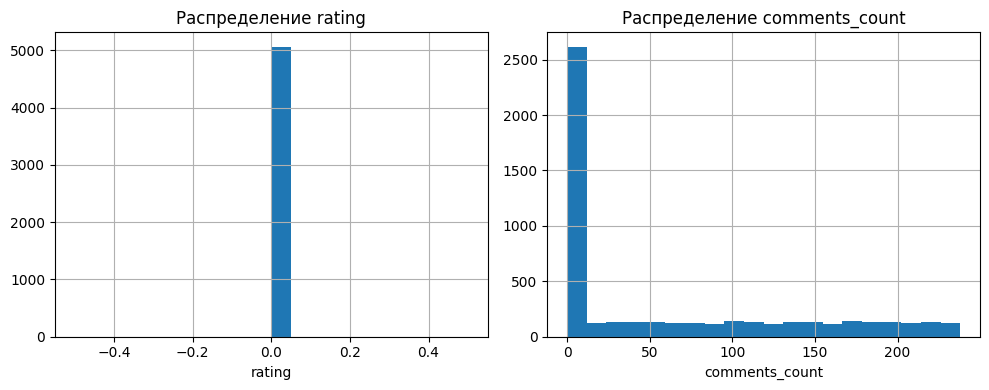

In [ ]:

print("Пропуски в comments_count:", df["comments_count"].isna().sum())
print("Пропуски в rating:", df["rating"].isna().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df["rating"].hist(ax=axes[0], bins=20)
axes[0].set_title("Распределение rating")
axes[0].set_xlabel("rating")

df["comments_count"].hist(ax=axes[1], bins=20)
axes[1].set_title("Распределение comments_count")
axes[1].set_xlabel("comments_count")

plt.tight_layout()
plt.show()


## Преобразование текстовых данных

In [ ]:
STOP_RU = set(stopwords.words("russian"))
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)
morph = MorphAnalyzer()

def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if pd.isna(text):
        return []

    text = str(text).lower()
    text = re.sub(r'[^а-яёa-z0-9\s]', ' ', text)  # Удаление лишних спецсимволов
    tokens = TOKEN_RE.findall(text)  # Токенизация

    lemmas = []
    for token in tokens:
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-яё]", token):
            # Русское слово: проверка стоп-слов + лемматизация
            if token in STOP_RU:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in STOP_RU:
                continue
        else:
            # Латинское/английское слово — оставляем как есть (но проверяем длину)
            if token in STOP_RU:  # Английские стоп-слова
                continue
            lemma = token

        lemmas.append(lemma)

    return lemmas

tokenized_texts = df['description'].astype(str).apply(preprocess_text).tolist()

# Проверка результата
print(f"\nОбработано {len(tokenized_texts)} новостей")
print(f"Среднее количество токенов на новость: {np.mean([len(tokens) for tokens in tokenized_texts]):.1f}")

print(f"\nПример обработанного текста (первая новость):")
print(f"Исходный текст (первые 200 символов):")
print(f"  {df['description'].iloc[0][:200]}...")
print(f"Токены (первые 20): {tokenized_texts[0][:20]}")
print(f"Количество токенов в первой новости: {len(tokenized_texts[0])}")



Обработано 5062 новостей
Среднее количество токенов на новость: 208.3

Пример обработанного текста (первая новость):
Исходный текст (первые 200 символов):
  Расследование нападения на двух шестиклассников в Фокино поставлено под личный контроль руководства СК России, сообщила пресс-служба Следкома Приморья.
"Глава ведомстваАлександр Бастрыкиндал поручение...
Токены (первые 20): ['расследование', 'нападение', 'шестиклассник', 'фокино', 'поставить', 'личный', 'контроль', 'руководство', 'россия', 'сообщить', 'пресс', 'служба', 'следкома', 'приморье', 'глава', 'ведомстваалександр', 'бастрыкиндал', 'поручение', 'руководитель', 'россия']
Количество токенов в первой новости: 78


## Обучение Модели Word2Vec

In [ ]:
w2v = Word2Vec(
    sentences=tokenized_texts,  #тексты для обучения
    vector_size=100,            # Размер вектора для каждого слова
    window=5,                   # Сколько слов слева+справа учитывать как контекст
    min_count=5,                # Игнорировать редкие слова (встречаются менее 5 раз)
    workers=4,                  # Количество процессоров для ускорения обучения
    sg=1,                       # Skip-gram(1)=предсказываем контекст по слову / CBOW(0)=слово по контексту
    epochs=10,                  # Сколько раз пройти весь корпус (итераций обучения)
    seed=42                     # Фиксированный номер для одинаковых результатов
)

# Функция для получения вектора документа
def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_vectors = np.vstack([doc_vector(t, w2v) for t in tokenized_texts])
print(f"Размер словаря: {len(w2v.wv)}")
print(f"Размер матрицы векторов: {doc_vectors.shape}")

Размер словаря: 14789
Размер матрицы векторов: (5062, 100)


## Обработка числовых признаков

In [ ]:
num_cols = ['comments_count', 'rating']
numeric = df[num_cols].values

# Заполнение пропусков медианой
imputer = SimpleImputer(strategy='median')
numeric_imputed = imputer.fit_transform(numeric)

# Стандартизация числовых признаков
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_imputed)

## Снижение размерности через PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
doc_vectors_2d = pca.fit_transform(doc_vectors)

doc_vectors_2d[:5]

array([[ 0.6595214 ,  0.12889747],
       [-0.1444713 ,  0.09847237],
       [ 0.16898615,  0.35389077],
       [ 0.6892231 , -0.21664276],
       [ 0.16973926, -0.06724835]])

In [ ]:
N_DOCS = len(df)

# Добавление координат к датафрейму, чтобы удобно было визуализировать
df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()

,guid,title,url,source,description,published_at,comments_count,created_at,rating,pca_x,pca_y
0,0415db56-d0e8-4934-8e5e-8f2513a56222,Бастрыкин взял под контроль расследование изби...,https://primamedia.ru/news/2317942/,PrimaMedia,Расследование нападения на двух шестикласснико...,2025-01-01,225,2025-12-03 07:35:48.753631+00:00,0,0.659521,0.128897
1,ffd6885a-4ef5-491c-a188-1332ba9230ec,Повышенная ставка утильсбора способствует укре...,https://primamedia.ru/news/2317803/,PrimaMedia,Решение правительства РФ о повышении ставки ут...,2025-01-01,92,2025-12-03 07:35:50.983567+00:00,0,-0.144471,0.098472
2,c3aa5f63-b5ef-4770-83f9-8208145308f5,Сберстрахование лидирует по страхованию имущес...,https://primamedia.ru/news/2317948/,PrimaMedia,Сборы СберСтрахования в январе — сентябре 2025...,2025-01-01,89,2025-12-03 07:35:53.231311+00:00,0,0.168986,0.353891
3,be04011b-2375-4414-8a20-abb4363d5585,Сразу пять автомобилей столкнулись в массовом ...,https://primamedia.ru/news/2317918/,PrimaMedia,Крупное ДТП с участием пяти автомобилей произо...,2025-01-01,112,2025-12-03 07:35:55.493146+00:00,0,0.689223,-0.216643
4,8cc2f4dd-52a4-42e8-9ac3-b0efb656ec6a,"Первый в регионе: ""умный"" светофор нового поко...",https://primamedia.ru/news/2317722/,PrimaMedia,Работы по подключению нового светофорного конт...,2025-01-01,0,2025-12-03 07:35:57.695216+00:00,0,0.169739,-0.067248


## Кластеризация (DBSCAN)

**DBSCAN** — это метод кластеризации, который работает по принципу **"плотности точек"**. Работает по принципу:
1. Берёт точку и смотрит на её "соседей" в радиусе eps
2. Если соседей много (min_samples) — это центр кластера
3. Расширяет кластер, соединяя близкие точки
4. Изолированные точки помечает как "шум" (-1)

**Преимущества DBSCAN:**
* Автоматически определяет количество кластеров
* **Можно использовать смешанные признаки (Word2Vec + числа)**
* Выделяет шум отдельно


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([3061, 1406,   15,  315,   21,   16,   40,   28,   12,    6,    6,
          8,   10,   11,    4,    7,    8,   15,    4,    9,    8,    5,
          9,   10,    6,    8,    7,    7]))


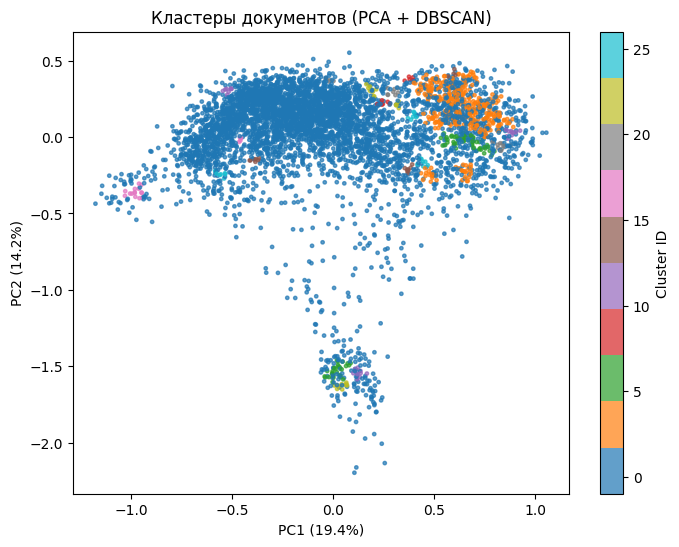

In [ ]:
import matplotlib.pyplot as plt

X_features = np.hstack([doc_vectors_2d, numeric_scaled])

dbscan = DBSCAN(eps=0.035, min_samples=7)
# dbscan = DBSCAN(eps=0.045, min_samples=5)

cluster_labels = dbscan.fit_predict(X_features)

# -1 в DBSCAN означает "шум"
print(np.unique(cluster_labels, return_counts=True))

df_subset["cluster"] = cluster_labels
df_subset[["title", "cluster"]].head(10)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов (PCA + DBSCAN)")
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.show()

PC1 и PC2 — это новые координаты, которые PCA (метод главных компонент) создал из признаков Word2Vec.

**PC1** 19.4% — разделяет новости по "теме" (политика/спорт и пр)
* Ось X	Показывает главное направление разброса

**PC2** 14.1% — разделяет по "тону" (позитив/негатив) внутри темы
* Ось Y	Показывает второе по важности направление

---

Объяснение малого % (33.5%):
1. Word2Vec = 100 "умных" признаков (семантика слов)
2. Информация равномерно распределена
3. Нет 1-2 доминирующих факторов
4. 19.4% + 14.1% = 33.5% на 2D — удобно для визуализации

In [ ]:
# Запись кластеров в основной датафрейм
df['cluster'] = cluster_labels[:len(df)]  # Обрезаем до размера df

print("\nРаспределение кластеров:")
print(df['cluster'].value_counts().sort_index())


Распределение кластеров:
cluster
-1     3061
 0     1406
 1       15
 2      315
 3       21
 4       16
 5       40
 6       28
 7       12
 8        6
 9        6
 10       8
 11      10
 12      11
 13       4
 14       7
 15       8
 16      15
 17       4
 18       9
 19       8
 20       5
 21       9
 22      10
 23       6
 24       8
 25       7
 26       7
Name: count, dtype: int64


## Подготовка признаков для supervised-задачи

Decision Tree (Дерево решений)
Как работает:
* Рекурсивно делит пространство признаков на прямоугольные области
* На каждом узле выбирает признак, который лучше всего разделяет классы (максимизирует информационный прирост)
* Строит иерархическое дерево решений

In [ ]:
# Оставляем только объекты, которые DBSCAN отнёс к какому-то кластеру (cluster != -1)
mask_non_noise = df["cluster"] != -1
df_sup = df[mask_non_noise].copy()

print(f"Всего объектов для supervised-задачи: {len(df_sup)} из {len(df)}")

# Целевая переменная — номер кластера
y = df_sup["cluster"].astype(int)

y.value_counts().sort_index()

Всего объектов для supervised-задачи: 2001 из 5062


,count
cluster,
0,1406
1,15
2,315
3,21
4,16
5,40
6,28
7,12
8,6


In [ ]:
idx = df_sup.index.to_numpy()
doc_vectors_sup = doc_vectors[idx]

# Числовые признаки для кластеров
numeric_sup = numeric_imputed[idx]
numeric_sup_scaled = scaler.transform(numeric_sup)

# Объединяем
X = np.hstack([doc_vectors_sup, numeric_sup_scaled])

print(f"Проверка")
print(f"   X: {X.shape}")
print(f"   y: {y.shape} ({len(np.unique(y))} классов)")
print(f"   Классы: {np.unique(y)}")


Проверка
   X: (2001, 102)
   y: (2001,) (27 классов)
   Классы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


## Предсказание кластеров методом Decision Tree

k-NN (k-ближайших соседей)
Как работает:
* Классифицирует объект на основе k соседних точек в обучающем наборе
* Используется расстояние (euclidean или cosine) для поиска соседей
* Не строит модель, а сравнивает с обучающими данными (ленивое обучение)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Разобьём данные на train и test с сохранением соотношения кластеров (stratify=y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
dt_clf = DecisionTreeClassifier(
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
)

dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

Decision Tree accuracy: 0.8519134775374376

Classification report (Decision Tree):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       422
           1       0.00      0.00      0.00         5
           2       0.85      0.84      0.85        95
           3       0.50      0.50      0.50         6
           4       0.20      0.20      0.20         5
           5       0.22      0.17      0.19        12
           6       0.67      0.50      0.57         8
           7       0.00      0.00      0.00         4
           8       0.33      1.00      0.50         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.38      1.00      0.55         3
          12       0.75      1.00      0.86         3
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.50      0.50      0.50         

Микрокластеры:
* Кластеры 1,4,5,9-12,14-20
* F1=0.00-0.40)
* Support = 2-10
* Модель их путает (нормально при малом размере)

Основные метрики качества:
* precision (точность предсказания) - % правильных предсказаний среди всех "положительных"
* recall (полнота поиска) - % найденных "положительных" из всех настоящих
* f1-score (баланс)- баланс между Precision и Recall

Итоговые метрики качества:
* **accuracy** (главная метрика) - общая точность модели
* macro avg - невзвешенное среднее по всем кластерам
	* Получили низкое значение из-за микрокластеров (F1=0.00)
	* Каждый кластер весит практически одинаково
weighted avg - взвешенное среднее
	* учитывает размер кластеров
	* F1-score - реальное качество = 86%

## Предсказание кластеров методом k-NN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Базовый классификатор (без фиксированных гиперпараметров)
knn_base = KNeighborsClassifier()

# Сетка гиперпараметров для перебора
param_grid = {
    "n_neighbors": [3, 5, 10, 15, 25],
    "weights": ["uniform", "distance"],
    "metric": ["cosine", "euclidean"],
}

grid_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,          # 5-fold cross-validation
    n_jobs=-1,     # использовать все доступные ядра
    verbose=1,     # чтобы видеть прогресс
)


grid_knn.fit(X_train, y_train)

print("Лучшие параметры:", grid_knn.best_params_)
print("Лучший CV accuracy:", grid_knn.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Лучший CV accuracy: 0.8992857142857142


In [ ]:
best_knn = grid_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

print("k-NN (best) accuracy на тесте:", accuracy_score(y_test, y_pred_knn))
print("\nClassification report (k-NN best):")
print(classification_report(y_test, y_pred_knn))



k-NN (best) accuracy на тесте: 0.891846921797005

Classification report (k-NN best):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       422
           1       0.00      0.00      0.00         5
           2       0.81      0.97      0.88        95
           3       0.50      0.67      0.57         6
           4       0.50      0.20      0.29         5
           5       0.50      0.42      0.45        12
           6       0.71      0.62      0.67         8
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.50      0.33      0.40         3
          12       0.60      1.00      0.75         3
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00       